In [1]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from termcolor import colored as cl
from math import floor

In [2]:
start_date = datetime(2010,1,1)
end_date = datetime(2023,5,1)
data = yf.download("^IXIC ^NSEI", start = start_date, end = end_date, auto_adjust=True)[['Close']]
data.head()

[*********************100%***********************]  2 of 2 completed


Close             
                  ^IXIC        ^NSEI
Date                                
2010-01-04  2308.419922  5232.200195
2010-01-05  2308.709961  5277.899902
2010-01-06  2301.090088  5281.799805
2010-01-07  2300.050049  5263.100098
2010-01-08  2317.169922  5244.750000

In [3]:
# Correlation calulcation
common_days = data['Close']['^IXIC'].index.intersection(data['Close'].index)
nas = data['Close']['^IXIC'].loc[common_days]
nse = data['Close']['^NSEI'].loc[common_days]
corr = nas.corr(nse, method = 'pearson')
print('Correlation between two indices:', corr)
print('Strong correlation (coefficient near to 1) and positive')

Correlation between two indices: 0.9513138758576783
Strong correlation (coefficient near to 1) and positive


Text(0, 0.5, 'Close')

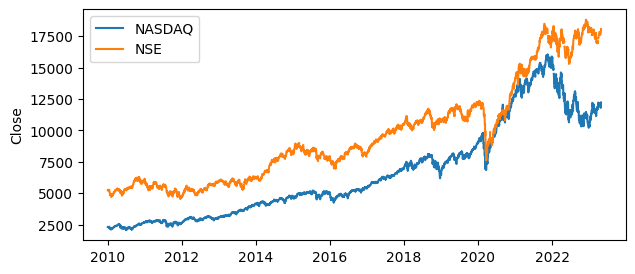

In [4]:
# Calculation of lead-lag relationship
plt.figure(figsize=(7,3))
plt.plot(nas, label='NASDAQ')
plt.plot(nse, label='NSE')
plt.legend(loc = "upper left", prop = {'size' : 10})
plt.ylabel('Close')

In [5]:
# Estimating lead-lag relationship
# Augmented Dicky Fuller test to check for stationarity of time series
from statsmodels.tsa.stattools import adfuller
def adftest(series):
    dftest = adfuller(series, autolag='AIC')
    result = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No of Observations'])
    for key,value in dftest[4].items(): result['Critical Value (%s)'%key] = value
    return result

In [6]:
# Checking for null values in the dataset
a = nas.isnull().sum()
b = nse.isnull().sum()
print(a, b)

# filling the nan values with avg of upper and lower value
nas = (nas.ffill()+nas.bfill())/2    # considered also the case when it has consecutive nans
nse = (nse.ffill()+nse.bfill())/2
nas = nas.bfill().ffill()  # if last or the first value is nan
nse = nse.bfill().ffill()

86 171


In [7]:
adftest(nas)


Test Statistic            -0.387187
P-value                    0.912216
Lags Used                 28.000000
No of Observations      3410.000000
Critical Value (1%)       -3.432269
Critical Value (5%)       -2.862388
Critical Value (10%)      -2.567221
dtype: float64

In [8]:
adftest(nse)


Test Statistic             0.251349
P-value                    0.974999
Lags Used                 10.000000
No of Observations      3428.000000
Critical Value (1%)       -3.432259
Critical Value (5%)       -2.862384
Critical Value (10%)      -2.567219
dtype: float64

In [9]:
# Series are non stationary
# Detrending the series
from numpy import polyfit

def fit(X, y, degree=5):
    coef = polyfit(X, y, degree)
    trendpoly = np.poly1d(coef)
    return trendpoly(X)

def get_trend(s, degree=5):
    X = list(range(len(s)))  # (s.index.year - s.index.year.min()).values
    trend = fit(X, s.values, degree)
    return pd.Series(data=trend, index=s.index)

In [10]:
tnas = get_trend(nas)
tnse= get_trend(nse)
nasdet = nas - tnas
nsedet = nse - tnse

Text(0, 0.5, 'Close')

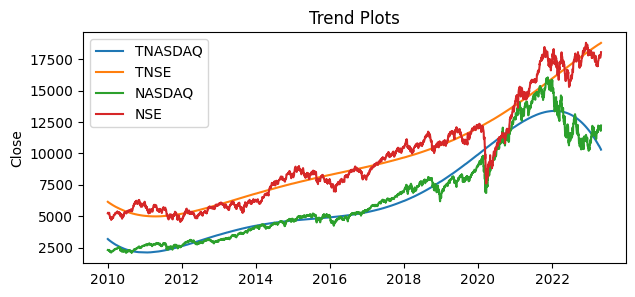

In [11]:
plt.figure(figsize=(7,3))
plt.title('Trend Plots')
plt.plot(tnas, label='TNASDAQ')
plt.plot(tnse, label='TNSE')
plt.plot(nas, label='NASDAQ')
plt.plot(nse, label='NSE')
plt.legend(loc = "upper left", prop = {'size' : 10})
plt.ylabel('Close')

Text(0, 0.5, 'Close')

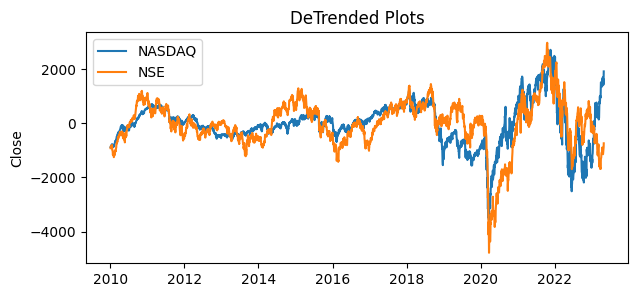

In [12]:
plt.figure(figsize=(7,3))
plt.title('DeTrended Plots')
plt.plot(nasdet, label='NASDAQ')
plt.plot(nsedet, label='NSE')
plt.legend(loc = "upper left", prop = {'size' : 10})
plt.ylabel('Close')

In [13]:
from scipy import signal
def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c

ccf = ccf_values(nasdet, nsedet)
lags = signal.correlation_lags(400, 400)
ccf = ccf[int((ccf.shape[0]-1)/2) - 399 :]
ccf = ccf[:799]
max_corr = max(ccf.min(), ccf.max(), key=abs)
max_index = np.where(ccf == max_corr)
print('max correlation between two indices:', max_corr, 'with lag =', lags[max_index[0]][0])

max correlation between two indices: 0.654780830766633 with lag = -1


In [14]:
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(7, 3))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation plot', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold',fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend(loc = "upper right", prop = {'size' : 10})

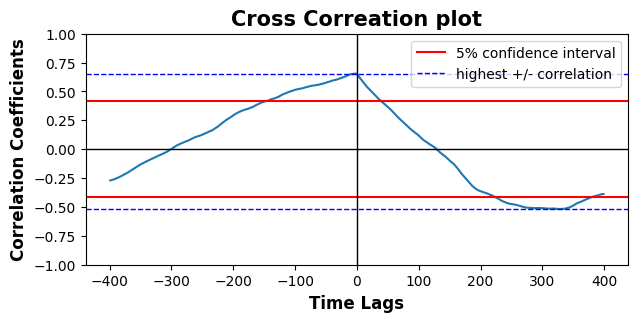

In [15]:
ccf_plot(lags, ccf)


In [18]:
# Indicator Coding
start_date = datetime(2010,1,1)
end_date = datetime(2023,5,1)
df = yf.download("^NSEI", start = start_date, end = end_date, auto_adjust=True)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,0


In [19]:
# Keltner Channel
def expmovavg(data):
    return data['Close'].ewm(span=20, adjust=False).mean()
    
def get_ATR(data):
    data['H-L'] = data['High'] - data['Low']
    data['H-C'] = abs(data['High'] - data['Close'].shift(1))
    data['C-L'] = abs(data['Close'].shift(1) - data['Low'])
    data['TrueRange'] = data[['H-L', 'H-C', 'C-L']].max(axis=1)
    data['ATR'] = data['TrueRange'].rolling(window=10).mean()
    return data['ATR']

EMA = expmovavg(df)
ATR = get_ATR(df)
upper_band = EMA + (2*ATR)
lower_band = EMA - (2*ATR)

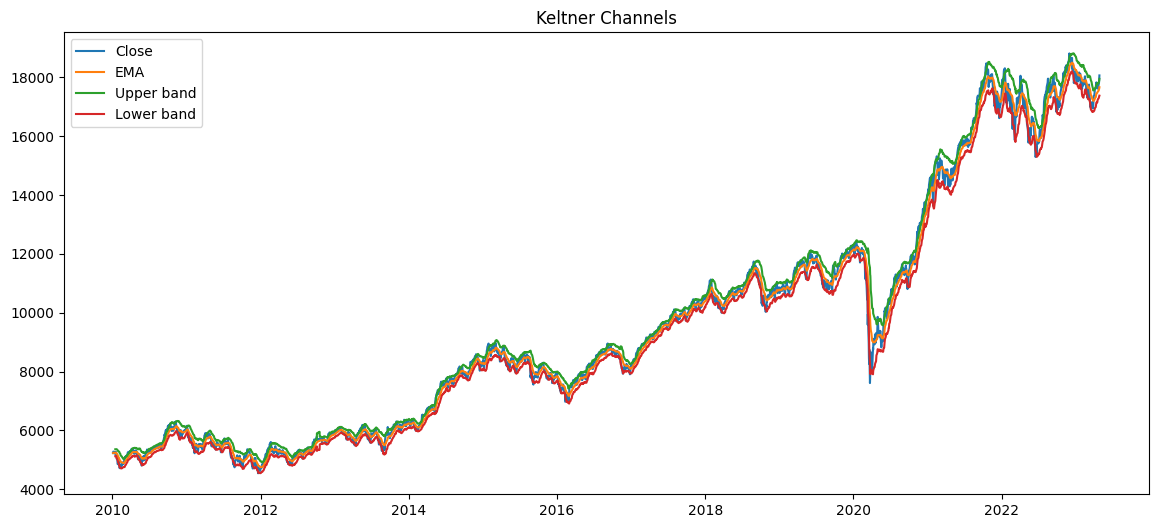

In [20]:
plt.figure(figsize=(14,6))
plt.title('Keltner Channels')
plt.plot(df['Close'], label='Close')
plt.plot(EMA, label='EMA')
plt.plot(upper_band, label='Upper band')
plt.plot(lower_band, label='Lower band')
plt.legend(loc = "upper left", prop = {'size' : 10})

In [23]:
# Parameter optimization and signal generation  
# Keltner channel strategy (breakout strategy)
def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0

    for i in range(len(prices)-1):
        if prices[i] < kc_lower[i] and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
    return buy_price, sell_price, kc_signal

In [24]:
buy_price, sell_price, kc_signal = implement_kc_strategy(df['Close'], upper_band, lower_band)


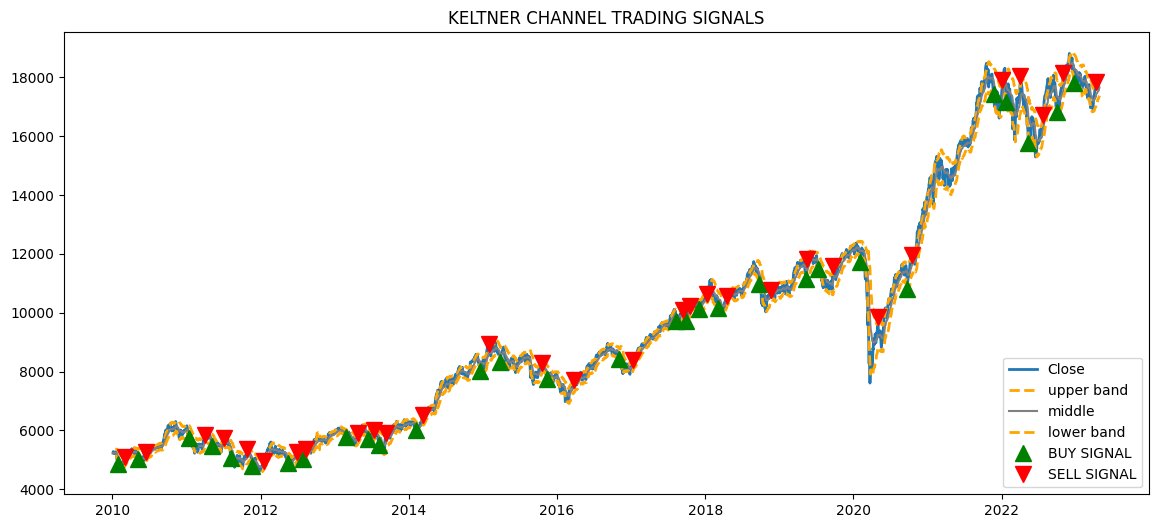

In [25]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], linewidth = 2, label = 'Close')
plt.plot(upper_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'upper band')
plt.plot(EMA, linewidth = 1.5, color = 'grey', label = 'middle')
plt.plot(lower_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'lower band')
plt.plot(df.index[:3267], buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(df.index[:3267], sell_price, marker = 'v', color= 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('KELTNER CHANNEL TRADING SIGNALS')
plt.show()

In [26]:
position = []
for i in range(len(kc_signal)):
    if kc_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(0,len(df['Close'])-1):
    if kc_signal[i] == 1:
        position[i] = 1
    elif kc_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
kc_signal = pd.DataFrame(kc_signal).rename(columns = {0:'kc_signal'}).set_index(df[:3267].index)
position = pd.DataFrame(position).rename(columns = {0:'kc_position'}).set_index(df[:3267].index)
frames = [df['Close'], upper_band, lower_band, kc_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)
strategy.head()
# backtesting
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
kc_strategy_ret = []
for i in range(len(df_ret)):
    returns = df_ret['returns'][i]*strategy['kc_position'][i]
    kc_strategy_ret.append(returns)

kc_strategy_ret_df = pd.DataFrame(kc_strategy_ret).rename(columns = {0:'kc_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['Close'][0])
kc_investment_ret = []
for i in range(len(kc_strategy_ret_df['kc_returns'])):
    returns = number_of_stocks*kc_strategy_ret_df['kc_returns'][i]
    kc_investment_ret.append(returns)

In [27]:
# ratios
buy_price_list = [x for x in buy_price if x == x]
sell_price_list = [x for x in sell_price if x == x]
buy_price_list = np.array(buy_price_list)
sell_price_list = np.array(sell_price_list)
returns = ((sell_price_list - buy_price_list)/buy_price_list)*100

In [28]:
# sharpe ratio
SR = returns.mean()/returns.std()
# MDD
MDD = returns.min()
# cumulative return
cmm_return = returns.sum()

print(SR, MDD, cmm_return)

0.7853040917015882 -15.784213551046012 114.99319644917716


In [29]:
# Bollinger Bands
df_mean = df['Close'].rolling(window=20).mean()
df_std = df['Close'].rolling(window=20).std()
upper_band = df_mean + (df_std * 2)
lower_band = df_mean - (df_std * 2)

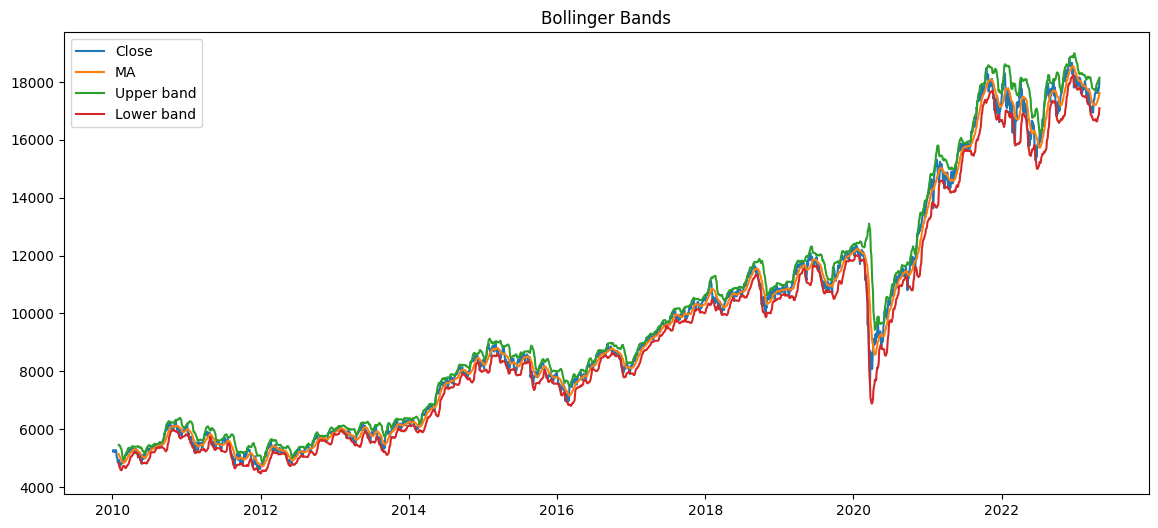

In [30]:
plt.figure(figsize=(14,6))
plt.title('Bollinger Bands')
plt.plot(df['Close'], label='Close')
plt.plot(df_mean, label='MA')
plt.plot(upper_band, label='Upper band')
plt.plot(lower_band, label='Lower band')
plt.legend()

In [31]:
# Parameter optimization and signal generation  
# Bollinger bands strategy
def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
        
        return buy_price, sell_price, bb_signal

In [32]:
buy_price, sell_price, bb_signal = implement_bb_strategy(df['Close'], lower_band, upper_band)

ValueError: x and y must have same first dimension, but have shapes (3268,) and (1,)

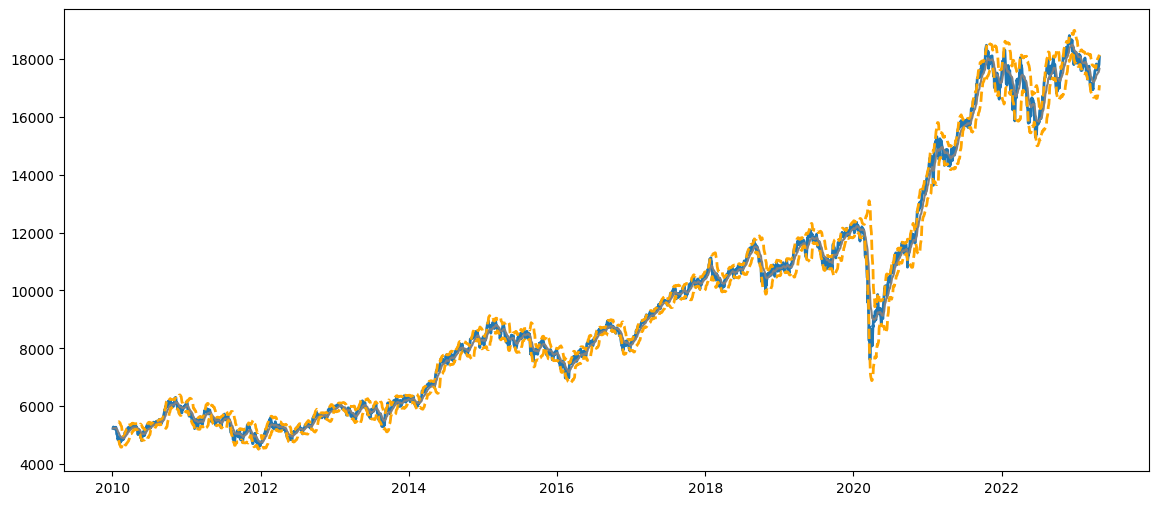

In [46]:
plt.figure(figsize=(14,6))
plt.plot(df['Close'], linewidth = 2, label = 'Close')
plt.plot(upper_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'upper band')
plt.plot(EMA, linewidth = 1.5, color = 'grey', label = 'middle')
plt.plot(lower_band, linewidth = 2, color = 'orange', linestyle = '--', label = 'lower band')
plt.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(df.index, sell_price, marker = 'v', color= 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('Bollinger band TRADING SIGNALS')
plt.show()

In [47]:
position = []
for i in range(len(bb_signal)):
    if bb_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['Close'])):
    if bb_signal[i] == 1:
        position[i] = 1
    elif bb_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df.index)

frames = [df['Close'], upper_band, lower_band, bb_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy.head()
# backtesting
df_ret = pd.DataFrame(np.diff(df['Close'])).rename(columns = {0:'returns'})
bb_strategy_ret = []
for i in range(len(df_ret)):
    returns = df_ret['returns'][i]*strategy['bb_position'][i]
    bb_strategy_ret.append(returns)

bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/df['Close'][0])
bb_investment_ret = []
for i in range(len(bb_strategy_ret_df['bb_returns'])):
    returns = number_of_stocks*bb_strategy_ret_df['bb_returns'][i]
    bb_investment_ret.append(returns)

IndexError: list index out of range

In [48]:
buy_price_list = [x for x in buy_price if x == x]
sell_price_list = [x for x in sell_price if x == x]
buy_price_list = np.array(buy_price_list)
sell_price_list = np.array(sell_price_list)
returns = ((sell_price_list[1:] - buy_price_list)/buy_price_list)*100

In [49]:
# ratios
# sharpe ratio
SR = returns.mean()/returns.std()
# MDD
MDD = returns.min()
# cumulative return
cmm_return = returns.sum()

print(SR, MDD, cmm_return)

C:\Users\HP\AppData\Local\Temp\ipykernel_24568\3513464996.py:3: RuntimeWarning: Mean of empty slice.
  SR = returns.mean()/returns.std()
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity